## Preparing Data

### Number of Images and Labels and its shapes

In [1]:
import os
import cv2

images_dir = '/mnt/0D6BEAD6291820B7/Wilgo/Datasets/sugar_beets/rgb'
masks_dir = '/mnt/0D6BEAD6291820B7/Wilgo/Datasets/sugar_beets/labels'

# Contagem de arquivos
num_images = len(os.listdir(images_dir))
num_masks = len(os.listdir(masks_dir))

print(f'Número de arquivos RGB: {num_images}')
print(f'Número de arquivos de máscara: {num_masks}')
print(f'Diferença: {abs(num_images - num_masks)}')

# Lê o primeiro arquivo de cada pasta para verificar shape
first_img_path = os.path.join(images_dir, sorted(os.listdir(images_dir))[0])
first_mask_path = os.path.join(masks_dir, sorted(os.listdir(masks_dir))[0])

img = cv2.imread(first_img_path)
mask = cv2.imread(first_mask_path)

print(f'Shape da primeira imagem RGB: {img.shape}')
print(f'Shape da primeira máscara: {mask.shape}')


Número de arquivos RGB: 306
Número de arquivos de máscara: 283
Diferença: 23
Shape da primeira imagem RGB: (966, 1296, 3)
Shape da primeira máscara: (966, 1296, 3)


### Join the pairs (image and label)

In [2]:
import os

# Caminhos
images_dir = '/mnt/0D6BEAD6291820B7/Wilgo/Datasets/sugar_beets/rgb'
masks_dir = '/mnt/0D6BEAD6291820B7/Wilgo/Datasets/sugar_beets/labels'

image_paths = []
mask_paths = []

for i in range(23, 306):  # 306 porque o final (305) é incluído
    img_name = f"rgb_{i:05d}.png"
    mask_name = f"bonirob_2016-05-23-10-37-10_0_frame{i}_GroundTruth_color.png"

    img_path = os.path.join(images_dir, img_name)
    mask_path = os.path.join(masks_dir, mask_name)

    if os.path.exists(img_path) and os.path.exists(mask_path):
        image_paths.append(img_path)
        mask_paths.append(mask_path)
    else:
        print(f"⚠️ Arquivo ausente: {img_name} ou {mask_name}")

print(f"✅ Total de pares válidos: {len(image_paths)}")


✅ Total de pares válidos: 283


### Plot the images and color masks

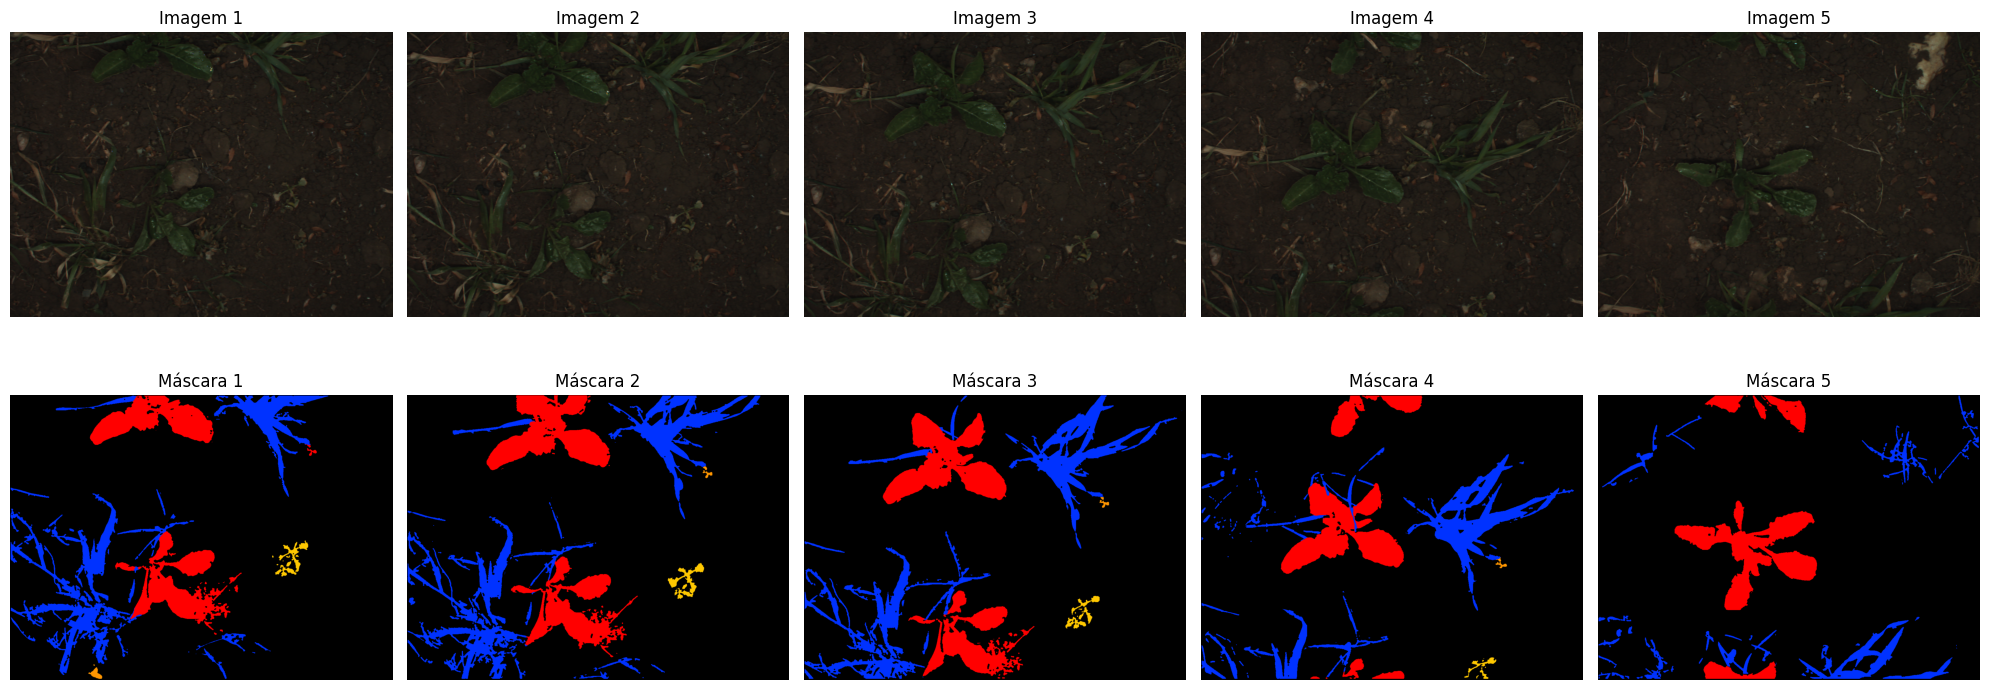

In [3]:
import matplotlib.pyplot as plt
import cv2
import os

# Inicializa figuras
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
shown = 0  # contador de pares válidos

idx = 0
while shown < 5 and idx < len(image_paths):
    img_path = image_paths[idx]
    mask_path = mask_paths[idx]

    # Verifica se ambos os arquivos existem
    if os.path.exists(img_path) and os.path.exists(mask_path):
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        # Confirma que carregaram corretamente
        if img is not None and mask is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

            axs[0, shown].imshow(img)
            axs[0, shown].set_title(f"Imagem {idx + 1}")
            axs[0, shown].axis('off')

            axs[1, shown].imshow(mask)
            axs[1, shown].set_title(f"Máscara {idx + 1}")
            axs[1, shown].axis('off')

            shown += 1

    idx += 1

plt.tight_layout()
plt.show()


### Tranform color mask in class mask

In [4]:
import cv2
import numpy as np
from tqdm import tqdm

# Mapeamento de cores para índices de classe
COLOR_MAP = {
    (0, 0, 0): 0,            # Solo
    (255, 0, 0): 1,          # Cultura
    (0, 50, 255): 2,         # Daninha (variação de azul)
    (255, 150, 0): 3,        # Outra classe (amarelo escuro)
    (255, 200, 0): 3         # Outra classe (amarelo claro)
}

def convert_mask_to_class(mask_rgb):
    mask_class = np.zeros(mask_rgb.shape[:2], dtype=np.uint8)
    for color, class_idx in COLOR_MAP.items():
        matches = np.all(mask_rgb == color, axis=-1)
        mask_class[matches] = class_idx
    return mask_class

# Lista com todas as máscaras convertidas
masks_class = []

# Loop pelos arquivos de máscara
for path in tqdm(mask_paths, desc="Convertendo máscaras"):
    mask_rgb = cv2.imread(path)
    if mask_rgb is None:
        continue
    mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB)
    mask_class = convert_mask_to_class(mask_rgb)
    masks_class.append(mask_class)


Convertendo máscaras: 100%|██████████| 283/283 [00:40<00:00,  7.07it/s]


In [5]:
import numpy as np

mask = masks_class[3]
total_pixels = mask.size
classes, counts = np.unique(mask, return_counts=True)

print("Distribuição percentual das classes:")
for cls, count in zip(classes, counts):
    percent = (count / total_pixels) * 100
    print(f"Classe {cls}: {percent:.2f}%")


print("Shape da máscara original (RGB):", mask_rgb.shape)
print("Shape da máscara convertida (indexada):", mask_class.shape)


Distribuição percentual das classes:
Classe 0: 87.36%
Classe 1: 6.00%
Classe 2: 6.47%
Classe 3: 0.17%
Shape da máscara original (RGB): (966, 1296, 3)
Shape da máscara convertida (indexada): (966, 1296)


## Dataset and Traning

### Creating dataset for training

In [6]:
import cv2
import numpy as np
from tqdm import tqdm

# Listas para armazenar todos os patches do dataset
all_img = []
all_mask = []

# Aplica para cada par imagem-máscara
for img_path, mask_path in tqdm(zip(image_paths, mask_paths), total=len(image_paths), desc="Extracting images and masks"):
    # Carrega imagem RGB
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Carrega máscara e converte
    mask_rgb = cv2.imread(mask_path)
    mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB)
    mask_class = convert_mask_to_class(mask_rgb)

    all_img.append(image)
    all_mask.append(mask_class)

# Confirma
print(f"\nTotal of images and masks: {len(all_img)}")
print(f"Shape each one images: {all_img[0].shape}, mask: {all_mask[0].shape}")


Extracting images and masks: 100%|██████████| 283/283 [00:45<00:00,  6.18it/s]


Total of images and masks: 283
Shape each one images: (966, 1296, 3), mask: (966, 1296)


### Dataset (Split)

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import torchvision.models.segmentation as segmentation
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time
import gc

# Dataset
class PatchDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32) / 255.0
        mask = self.masks[idx].astype(np.int64)
        image = np.transpose(image, (2, 0, 1))
        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.long)

dataset = PatchDataset(all_img, all_mask)

# Split: 70% train, 15% calibration, 15% test
train_size = int(0.7 * len(dataset))
calibration_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - calibration_size
train_dataset, calibration_dataset, test_dataset = random_split(
    dataset, [train_size, calibration_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Calibration split: A (validação) e B (conformal)
calibration_size_A = len(calibration_dataset) // 2
calibration_size_B = len(calibration_dataset) - calibration_size_A
calibration_A, calibration_B = random_split(
    calibration_dataset, [calibration_size_A, calibration_size_B],
    generator=torch.Generator().manual_seed(42)
)

# DataLoaders com batch_size reduzido
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
calibration_loader_A = DataLoader(calibration_A, batch_size=batch_size, shuffle=False)
calibration_loader_B = DataLoader(calibration_B, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train: {len(train_dataset)}")
print(f"Calibration A (Validação): {len(calibration_A)}")
print(f"Calibration B (Conformal): {len(calibration_B)}")
print(f"Test: {len(test_dataset)}")

Train: 198
Calibration A (Validação): 21
Calibration B (Conformal): 21
Test: 43


### Model

#### DeepLabV3

In [8]:
# Modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = segmentation.deeplabv3_mobilenet_v3_large(weights='DEFAULT')
model.classifier[4] = nn.Conv2d(256, 4, kernel_size=(1, 1))
model = model.to(device)

# Loss e otimizador
class_weights = torch.tensor([0.5, 1.0, 2.0, 0.5]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Mixed precision
scaler = torch.cuda.amp.GradScaler()

# Salvar melhor modelo
def save_best_model(model, path, iou_score, best_iou):
    if iou_score > best_iou:
        print(f"New best model! IoU: {iou_score:.4f}")
        torch.save(model.state_dict(), path)
        return iou_score
    return best_iou

# Treinamento usando mixed precision
def train_model(model, train_loader, val_loader, epochs=10):
    best_iou = 0.0
    for epoch in range(epochs):
        print(f"\n=== Epoch {epoch+1}/{epochs} ===")
        model.train()
        train_loss = 0.0
        start_time = time.time()

        for images, masks in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(images)['out']
                loss = criterion(outputs, masks)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()

            # Libera memória
            torch.cuda.empty_cache()
            gc.collect()

        print(f"Training Loss: {train_loss/len(train_loader):.4f}")

        # Validação
        model.eval()
        val_loss = 0.0
        iou_scores = np.zeros(4)
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)['out']
                    loss = criterion(outputs, masks)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                for cls in range(4):
                    intersection = ((preds == cls) & (masks == cls)).sum().item()
                    union = ((preds == cls) | (masks == cls)).sum().item()
                    iou = intersection / union if union != 0 else 0
                    iou_scores[cls] += iou

                torch.cuda.empty_cache()
                gc.collect()

        iou_scores /= len(val_loader)
        mean_iou = np.mean(iou_scores)
        print(f"Validation Loss: {val_loss/len(val_loader):.4f}")
        for cls_idx, iou_score in enumerate(iou_scores):
            print(f"Class {cls_idx} IoU: {iou_score:.4f}")
        print(f"Mean IoU: {mean_iou:.4f}")

        best_iou = save_best_model(model, "best_model.pth", mean_iou, best_iou)

        if device.type == "cuda":
            print(f"GPU memory used: {torch.cuda.memory_allocated() / 1024 ** 2:.2f} MB")

# Rodar treinamento
train_model(model, train_loader, calibration_loader_A, epochs=10)

Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /home/wilgo/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth
100%|██████████| 42.3M/42.3M [00:03<00:00, 11.5MB/s]
/tmp/ipykernel_192765/292942538.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



=== Epoch 1/10 ===


Training Epoch 1:   0%|          | 0/99 [00:00<?, ?it/s]/tmp/ipykernel_192765/292942538.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training Epoch 1: 100%|██████████| 99/99 [00:25<00:00,  3.96it/s]
/tmp/ipykernel_192765/292942538.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training Loss: 0.2270
Validation Loss: 0.5491
Class 0 IoU: 0.9474
Class 1 IoU: 0.0000
Class 2 IoU: 0.0075
Class 3 IoU: 0.0000
Mean IoU: 0.2387
New best model! IoU: 0.2387
GPU memory used: 223.60 MB

=== Epoch 2/10 ===


Training Epoch 2: 100%|██████████| 99/99 [00:24<00:00,  4.03it/s]


Training Loss: 0.0996
Validation Loss: 0.6049
Class 0 IoU: 0.9448
Class 1 IoU: 0.0000
Class 2 IoU: 0.0134
Class 3 IoU: 0.0000
Mean IoU: 0.2395
New best model! IoU: 0.2395
GPU memory used: 223.98 MB

=== Epoch 3/10 ===


Training Epoch 3: 100%|██████████| 99/99 [00:24<00:00,  4.02it/s]


Training Loss: 0.0856
Validation Loss: 0.6292
Class 0 IoU: 0.9397
Class 1 IoU: 0.0000
Class 2 IoU: 0.0418
Class 3 IoU: 0.0000
Mean IoU: 0.2454
New best model! IoU: 0.2454
GPU memory used: 223.22 MB

=== Epoch 4/10 ===


Training Epoch 4: 100%|██████████| 99/99 [00:24<00:00,  4.02it/s]


Training Loss: 0.0739
Validation Loss: 0.2924
Class 0 IoU: 0.9554
Class 1 IoU: 0.1174
Class 2 IoU: 0.2431
Class 3 IoU: 0.0000
Mean IoU: 0.3290
New best model! IoU: 0.3290
GPU memory used: 223.87 MB

=== Epoch 5/10 ===


Training Epoch 5: 100%|██████████| 99/99 [00:24<00:00,  4.02it/s]


Training Loss: 0.0688
Validation Loss: 0.0937
Class 0 IoU: 0.9750
Class 1 IoU: 0.7485
Class 2 IoU: 0.3906
Class 3 IoU: 0.0212
Mean IoU: 0.5338
New best model! IoU: 0.5338
GPU memory used: 223.87 MB

=== Epoch 6/10 ===


Training Epoch 6: 100%|██████████| 99/99 [00:24<00:00,  4.03it/s]


Training Loss: 0.0681
Validation Loss: 0.0785
Class 0 IoU: 0.9760
Class 1 IoU: 0.7924
Class 2 IoU: 0.4168
Class 3 IoU: 0.0747
Mean IoU: 0.5650
New best model! IoU: 0.5650
GPU memory used: 223.87 MB

=== Epoch 7/10 ===


Training Epoch 7: 100%|██████████| 99/99 [00:24<00:00,  4.01it/s]


Training Loss: 0.0668
Validation Loss: 0.0729
Class 0 IoU: 0.9786
Class 1 IoU: 0.8147
Class 2 IoU: 0.4556
Class 3 IoU: 0.1662
Mean IoU: 0.6038
New best model! IoU: 0.6038
GPU memory used: 223.87 MB

=== Epoch 8/10 ===


Training Epoch 8: 100%|██████████| 99/99 [00:24<00:00,  4.01it/s]


Training Loss: 0.0618
Validation Loss: 0.0690
Class 0 IoU: 0.9777
Class 1 IoU: 0.8255
Class 2 IoU: 0.4534
Class 3 IoU: 0.1337
Mean IoU: 0.5976
GPU memory used: 223.87 MB

=== Epoch 9/10 ===


Training Epoch 9: 100%|██████████| 99/99 [00:24<00:00,  4.00it/s]


Training Loss: 0.0594
Validation Loss: 0.0771
Class 0 IoU: 0.9807
Class 1 IoU: 0.8354
Class 2 IoU: 0.4659
Class 3 IoU: 0.2413
Mean IoU: 0.6308
New best model! IoU: 0.6308
GPU memory used: 223.87 MB

=== Epoch 10/10 ===


Training Epoch 10: 100%|██████████| 99/99 [00:24<00:00,  4.00it/s]


Training Loss: 0.0570
Validation Loss: 0.0768
Class 0 IoU: 0.9795
Class 1 IoU: 0.8169
Class 2 IoU: 0.4424
Class 3 IoU: 0.2221
Mean IoU: 0.6152
GPU memory used: 223.87 MB


### Save the logits

In [9]:
import torch
from tqdm import tqdm

def save_logits_masks_images(model, loader, save_path):
    model.eval()
    all_logits = []
    all_masks = []
    all_images = []

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Saving logits, masks and images"):
            images = images.to(device)
            outputs = model(images)['out']

            all_logits.append(outputs.cpu())
            all_masks.append(masks.cpu())
            all_images.append(images.cpu())

    all_logits = torch.cat(all_logits)
    all_masks = torch.cat(all_masks)
    all_images = torch.cat(all_images)

    save_dict = {
        "logits": all_logits,
        "masks": all_masks,
        "images": all_images
    }

    torch.save(save_dict, save_path)
    print(f"Logits, masks e images have saved at: {save_path}")

model.load_state_dict(torch.load("best_model.pth", weights_only=True))
save_logits_masks_images(model, calibration_loader_B, "calibration_logits.pth")
save_logits_masks_images(model, test_loader, "test_logits.pth")


Saving logits, masks and images: 100%|██████████| 11/11 [00:01<00:00, 10.13it/s]


Logits, masks e images have saved at: calibration_logits.pth


Saving logits, masks and images: 100%|██████████| 22/22 [00:02<00:00,  9.00it/s]


Logits, masks e images have saved at: test_logits.pth
